### Sentiment Analysis of Yelp Reviews

**Motivation**  
Opinions or sentiments can be expressed on different entities, such as a cell phone, a digital camera, or a bank. Opinions can also be expressed on features or aspects of entities e.g. the screen of a cell phone, the service of a restaurant, or the picture quality of a camera.  
  
Opinion Mining helps business houses to understand what consumers are saying and reporting about their products. While a positive sentiment may not boost the sales very much but the impact of single negative review is much more and that can hurt the sales and revenue quite significantly. Manual investigation of each review is costly and sometimes consumers do not provide explicit ratings too. So, it is imperative that business houses would need an automated system to classify reviews as a positive or a negative review. The product management team can then take corrective actions based on the feedbacks and sentiment analysis. 

**Dataset**  
The dataset for this project was chosen from the RecSys Challenge 2013: Yelp business rating prediction hosted by Kaggle in 2013 https://www.kaggle.com/c/yelp-recsys-2013/data
Inline-style: 
![alt text](images/yelp.png "Yelp Sentiment Analysis")

In [1]:
# TODO: Possible Other things to try
# 1. Food Recognition - Named Entity Recognition on Foods? Identify the food names - Is there any corpus I can refer?
# 2. Co-relation between reviews marked as cool, funny, positive, negative and the social perceptions of the review
#    a study from Yahoo labs
#       https://labs.yahoo.com/publications/6690/if-it-funny-it-mean-understanding-social-perceptions-yelp-online-reviews
#    They found two interesting things. First, reviews voted as useful and funny are associated with lower user ratings and 
#    relatively negative tone in the review text. Second, reviews voted as cool tend to have a relatively positive tone and 
#    higher ratings. How to implement that?
# 3. Incorporate spelling correction e.g. aaammmazz and amazing are same, zucchini zuccini zuchinni are same.
# 4. Instead of Counter of most common words use Most Common adjectives of +ve reviews and -ve reviews 
#     e.g. amazing, wonderful, excellent, horrible, terrible
# 5. Count of most common words in +ve reviews and -ve reviews - DONE
# 6. Use a better/custom stop words list - DONE

In [2]:
# numerical modules
import pandas as pd
import numpy as np
import scipy as sp

# machine learning modules
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# text processing modules
from textblob import TextBlob, Word
from nltk.stem.porter import PorterStemmer

import heapq
from collections import Counter, OrderedDict

# wordcloud visualization
from wordcloud import WordCloud

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

D:\Work\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999999;

<IPython.core.display.Javascript object>

## 1. Data Loading

### 1.1 Read the yelp dataset

In [4]:
yelp_review_df = pd.read_csv('data/train/review.csv')

In [5]:
yelp_review_df.shape

(10000, 10)

In [6]:
# Check the first few reviews
yelp_review_df.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [7]:
# let's check the type, it should be review
yelp_review_df['type'].unique()

array(['review'], dtype=object)

### 1.2 Drop unnecessary columns

In [8]:
# business_id, date, user_id, type columns are irrelevant for this notebook
yelp_review_df.drop(['business_id', 'date', 'review_id', 'type', 'user_id'], axis=1, inplace=True)

In [9]:
yelp_review_df.head(5)

,stars,text,cool,useful,funny
0,5,My wife took me here on my birthday for breakf...,2,5,0
1,5,I have no idea why some people give bad review...,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0


### 1.3 Keep only the highly positive and highly negative reviews

In [10]:
yelp_review_df = yelp_review_df[(yelp_review_df['stars'] == 5) | (yelp_review_df['stars'] == 1)]

In [11]:
# let's look at some highly positive reviews
yelp_review_df[yelp_review_df['stars'] == 5].head(3)

,stars,text,cool,useful,funny
0,5,My wife took me here on my birthday for breakf...,2,5,0
1,5,I have no idea why some people give bad review...,0,0,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0


In [12]:
# let's look at some highly negative reviews
yelp_review_df[yelp_review_df['stars'] == 1].head(3)

,stars,text,cool,useful,funny
23,1,U can go there n check the car out. If u wanna...,0,1,1
31,1,Disgusting! Had a Groupon so my daughter and ...,0,1,0
35,1,"I've eaten here many times, but none as bad as...",0,4,3


### 1.4. Determine Null Accuracy

In [13]:
# Inspect how many are positive sentiment and how many are negative
yelp_review_df['stars'].value_counts()

5    3337
1     749
Name: stars, dtype: int64

D:\Work\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


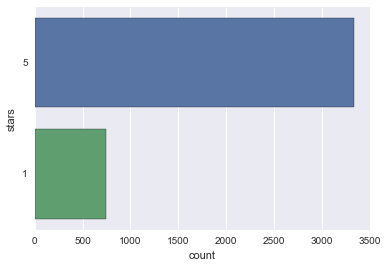

In [14]:
sns.countplot(y='stars', data=yelp_review_df);

In [15]:
ratio = float(len(yelp_review_df[yelp_review_df['stars'] == 5])) / (len(yelp_review_df[yelp_review_df['stars'] == 5]) + 
                                                                        len(yelp_review_df[yelp_review_df['stars'] == 1]))

In [16]:
print("Null Accuracy: %0.6f" % (ratio))

Null Accuracy: 0.816691


## 2. Sentiment Analysis with TextBlob

In [17]:
# print the first yelp review
print yelp_review_df.text[0]

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!


In [18]:
yelp_review_df.stars[0]

5

In [19]:
# polarity ranges from -1 (most negative) to 1 (most positive)
review = TextBlob(yelp_review_df.text[0])

In [20]:
review.sentiment.polarity

0.40246913580246907

In [21]:
review.sentiment.subjectivity

0.6591122868900646

### 2.1 Calculate Sentiment of Each Review with TextBlob

In [22]:
# create a new DataFrame column for sentiment
yelp_review_df['texblob_sentiment_score'] = yelp_review_df.text.apply(lambda x : TextBlob(x.decode('utf-8')).sentiment.polarity)

In [23]:
# let's look at some negative reviews
yelp_review_df[yelp_review_df['stars'] == 1].head(10)

,stars,text,cool,useful,funny,texblob_sentiment_score
23,1,U can go there n check the car out. If u wanna...,0,1,1,-0.264021
31,1,Disgusting! Had a Groupon so my daughter and ...,0,1,0,-0.099091
35,1,"I've eaten here many times, but none as bad as...",0,4,3,-0.035973
61,1,I have always been a fan of Burlington's deals...,0,0,0,-0.015278
64,1,Another night meeting friends here. I have to...,0,1,2,-0.063456
65,1,Not busy at all but took nearly 45 min to get ...,0,1,0,0.016667
71,1,"Yikes, reading other reviews I realize my bad ...",0,6,1,-0.009365
79,1,This is my first year participating in Arizona...,0,0,0,0.054167
84,1,"really, I can't believe this place has receive...",1,1,3,0.130092
89,1,"I was really excited about this event, maybe m...",0,1,0,0.192386


In [24]:
# let's check a random negative review, 23 seems to tbe good candidate
print yelp_review_df.text[23]

U can go there n check the car out. If u wanna buy 1 there? That's wrong move! If u even want a car service from there? U made a biggest mistake of ur life!! I had 1 time asked my girlfriend to take my car there for an oil service, guess what? They ripped my girlfriend off by lying how bad my car is now. If without fixing the problem. Might bring some serious accident. Then she did what they said. 4 brand new tires, timing belt, 4 new brake pads. U know why's the worst? All of those above I had just changed 2 months before!!! What a trashy dealer is that? People, better off go somewhere!


In [25]:
# let's look at some positive reviews
yelp_review_df[yelp_review_df['stars'] == 5].head(10)

,stars,text,cool,useful,funny,texblob_sentiment_score
0,5,My wife took me here on my birthday for breakf...,2,5,0,0.402469
1,5,I have no idea why some people give bad review...,0,0,0,0.229773
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,0.608646
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0,0.468125
6,5,Drop what you're doing and drive here. After I...,7,7,4,0.300645
9,5,Nobuo shows his unique talents with everything...,0,1,0,0.158333
10,5,The oldish man who owns the store is as sweet ...,1,3,1,0.326389
11,5,Wonderful Vietnamese sandwich shoppe. Their ba...,1,1,0,0.608333
12,5,They have a limited time thing going on right ...,1,2,0,0.153022
17,5,okay this is the best place EVER! i grew up sh...,0,0,0,0.570635


In [26]:
# let's check a random predicted positive review, 17 seems to tbe good candidate
print yelp_review_df.text[17]

okay this is the best place EVER! i grew up shopping at the one in los gatos, and the one in Oakville. i was shock when i saw the best store in the world in Scottsdale and then not surprised at all. the have all the good stuff. from cheese down to wine. i can't tell you how happy i am that this store is here in Arizona. now if we could just get dean and deluca!


### 2.2 Let's see how TextBlob is performing

In [27]:
# reviews with most positive sentiment
yelp_review_df[yelp_review_df['texblob_sentiment_score'] == 1]['text'].head()

254    Our server Gary was awesome. Food was amazing....
347    3 syllables for this place. \r\nA-MAZ-ING!\r\n...
420                                    LOVE the food!!!!
459    Love it!!! Wish we still lived in Arizona as C...
679                                     Excellent burger
Name: text, dtype: object

In [28]:
# reviews with most negative sentiment
yelp_review_df[yelp_review_df['texblob_sentiment_score'] == -1]['text'].head()

773     This was absolutely horrible. I got the suprem...
1517                  Nasty workers and over priced trash
3266    Absolutely awful... these guys have NO idea wh...
4766                                       Very bad food!
5812        I wouldn't send my worst enemy to this place.
Name: text, dtype: object

**what is the minimum sentiment given by textblob for negative reviews?**

In [29]:
# what is the minimum sentiment given by textblob for negative reviews?
yelp_review_df[yelp_review_df['stars'] == 1]['texblob_sentiment_score'].min()

-1.0

**what is the maximum sentiment given by textblob for negative reviews?**

In [30]:
# what is the maximum sentiment given by textblob for negative reviews?
yelp_review_df[yelp_review_df['stars'] == 1]['texblob_sentiment_score'].max()

1.0

**positive sentiment in a 1-star review**

In [31]:
# positive sentiment in a 1-star review
yelp_review_df[(yelp_review_df['stars'] == 1) & (yelp_review_df['texblob_sentiment_score'] > 0.7)]

,stars,text,cool,useful,funny,texblob_sentiment_score
1781,1,If you like the stuck up Scottsdale vibe this ...,0,1,2,0.766667
6222,1,"My mother always told me, if I didn't have any...",1,2,1,0.750000
8833,1,The owner has changed hands & this place isn't...,0,1,0,1.000000


In [32]:
print yelp_review_df.text[1781]

If you like the stuck up Scottsdale vibe this is a good place for you. The food isn't impressive. Nice outdoor seating.


**what is the minimum sentiment given by textblob for positive reviews?**

In [33]:
# what is the minimum sentiment given by textblob for positive reviews?
yelp_review_df[yelp_review_df['stars'] == 5]['texblob_sentiment_score'].min()

-0.625

**what is the maximum sentiment given by textblob for positive reviews?**

In [34]:
# what is the maximum sentiment given by textblob for positive reviews?
yelp_review_df[yelp_review_df['stars'] == 5]['texblob_sentiment_score'].max()

1.0

**negative sentiment in a 5-star review**

In [35]:
# negative sentiment in a 5-star review
yelp_review_df[(yelp_review_df['stars'] == 5) & (yelp_review_df['texblob_sentiment_score'] < -0.3)]

,stars,text,cool,useful,funny,texblob_sentiment_score
390,5,RIP AZ Coffee Connection. :( I stopped by tw...,1,0,0,-0.302083
1287,5,"Obsessed. Like, I've-got-the-Twangy-Tart-withd...",3,3,5,-0.625000
3075,5,Unfortunately Out of Business.,0,2,0,-0.500000
3516,5,"Cashew brittle, almond brittle, bacon brittle!...",9,8,6,-0.375000
6726,5,"Brown bag chicken sammich, mac n cheese, fried...",0,0,0,-0.600000
9809,5,I have to tell you....\r\n\r\nI had their Jerk...,1,1,1,-0.397656


In [36]:
print yelp_review_df['text'][1287]

Obsessed. Like, I've-got-the-Twangy-Tart-withdrawal-shakes level of addiction to this place. Please make one in Arcadia! Pleeeaaassse.


### 2.3 Use TextBlob to calculate stars for the reviews

In [37]:
yelp_review_df['textblob_predicted_stars'] = yelp_review_df['texblob_sentiment_score'].apply(lambda x : 5 if x > 0.1 else 1)

In [38]:
yelp_review_df.head(3)

,stars,text,cool,useful,funny,texblob_sentiment_score,textblob_predicted_stars
0,5,My wife took me here on my birthday for breakf...,2,5,0,0.402469,5
1,5,I have no idea why some people give bad review...,0,0,0,0.229773,5
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,0.608646,5


### 2.4 TextBlob - Preformance Evaluation

In [39]:
print 'Textblob Accuracy', metrics.accuracy_score(yelp_review_df['stars'], yelp_review_df['textblob_predicted_stars'])

Textblob Accuracy 0.893538913363


## 3. Sentiment Classification with Logistic Regression

### 3.1 Tokenization,  Stemming & Lemmatization
After tokenizning the string into words, we use nltk PorterStemmer to stem the tokens.

In [40]:
import re, nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [41]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

english_stops = stopwords.words('english')

In [42]:
print english_stops

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [43]:
def simple_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)    
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
   
    return tokens

In [44]:
def stem_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
    # stem
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
   
    return stems

In [45]:
def lemma_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
    # lemmas
    lemmas = []
    for item in tokens:
        lemmas.append(lemmatizer.lemmatize(item))
        
    return lemmas

### 3.2 Bag Of Words Model

Here we will be using here is called a **bag-of-words** model. In this kind of model we simplify documents to a multi-set of terms frequencies. That means that, for our model, a document sentiment tag will depend on what words appear in that document, discarding any grammar or word order but keeping multiplicity.

#### 3.2.1 Counting Word Frequency

In [46]:
count_vect = CountVectorizer(analyzer = 'word', tokenizer=simple_tokenizer, lowercase=True)

In [47]:
review_tf = count_vect.fit_transform(yelp_review_df['text'])

In [48]:
# Numpy arrays are easy to work with, so convert the result to an array
review_tf_nd = review_tf.toarray()
review_tf_nd.shape

(4086L, 18458L)

In [49]:
# Take a look at how the Document Term Matrix looks
df = pd.DataFrame(review_tf_nd, columns=count_vect.get_feature_names())
df.head(5)

,aaa,aaaamazing,aaammmazzing,aaron,aback,abandoned,abandoning,abba,abbreviate,abbreviated,...,zuccini,zuchinni,zumba,zupa,zupas,zuzu,zuzus,zwftv,zwiebel,zzed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# let's look at the words in the vocabulary, first 100 and last 100
vocab = count_vect.get_feature_names()
print(vocab[:100]) # First 100 words
print(vocab[-100:]) # Last 100 words
#print(vocab)  # all 18k words

[u'aaa', u'aaaamazing', u'aaammmazzing', u'aaron', u'aback', u'abandoned', u'abandoning', u'abba', u'abbreviate', u'abbreviated', u'abby', u'abc', u'abdomen', u'abhor', u'abiding', u'abilities', u'ability', u'abilty', u'able', u'abodoba', u'abou', u'abound', u'abrasion', u'abroad', u'abrupt', u'absence', u'absent', u'absinthe', u'absoloutely', u'absolut', u'absolute', u'absolutely', u'absolutley', u'absolutly', u'absorb', u'absorption', u'abstain', u'abstained', u'abstract', u'absurd', u'abuelo', u'abundance', u'abundant', u'abuse', u'abused', u'abusive', u'abysmal', u'acacia', u'academy', u'acai', u'acapulco', u'accent', u'accented', u'accents', u'accept', u'acceptable', u'accepted', u'accepting', u'accepts', u'access', u'accessed', u'accessible', u'accessories', u'accessorize', u'accessory', u'accident', u'accidental', u'accidentally', u'accidently', u'acclaimed', u'accolades', u'accommodate', u'accommodated', u'accommodates', u'accommodating', u'accommodation', u'accommodations', u'

#### 3.2.2 Fun with World Clouds

**Let's find the most popular words that occur in postive reviews**

In [51]:
# calculate frequency distribution of words in positive reviews
dist = np.sum(review_tf_nd[np.where(yelp_review_df['stars'] == 5)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count 

In [52]:
# word_count sum sorted by value
counter.most_common(20)

[(u'great', 2011),
 (u'place', 1988),
 (u'food', 1679),
 (u'good', 1663),
 (u'like', 1278),
 (u'one', 1254),
 (u'get', 1108),
 (u'love', 1104),
 (u'time', 1063),
 (u'best', 970),
 (u'service', 901),
 (u'really', 879),
 (u'always', 846),
 (u'also', 841),
 (u'back', 767),
 (u'would', 717),
 (u'well', 689),
 (u'amazing', 618),
 (u'delicious', 579),
 (u'nice', 578)]

D:\Work\Anaconda2\lib\site-packages\PIL\ImageDraw.py:99: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


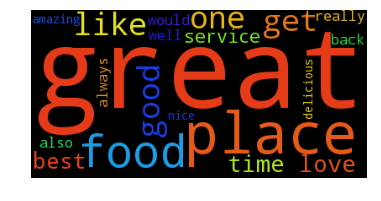

In [53]:
#wordcloud = WordCloud().fit_words(counter.items())
wordcloud = WordCloud().fit_words(counter.most_common(20))
plt.axis("off")
plt.imshow(wordcloud)

**Let's find the most popular words that occur in negative reviews**

In [54]:
# calculate frequency distribution of words in negative reviews
dist = np.sum(review_tf_nd[np.where(yelp_review_df['stars'] == 1)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count

In [55]:
# word_count sum sorted by value
counter.most_common(20)

[(u'food', 586),
 (u'place', 489),
 (u'like', 439),
 (u'one', 407),
 (u'get', 361),
 (u'would', 331),
 (u'service', 325),
 (u'back', 320),
 (u'time', 301),
 (u'good', 301),
 (u'even', 278),
 (u'never', 241),
 (u'minutes', 218),
 (u'order', 206),
 (u'got', 205),
 (u'ordered', 202),
 (u'didn', 198),
 (u'really', 194),
 (u'went', 192),
 (u'said', 187)]

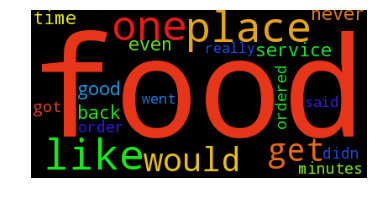

In [56]:
#wordcloud = WordCloud().fit_words(counter.items())
wordcloud = WordCloud().fit_words(counter.most_common(20))
plt.axis("off")
plt.imshow(wordcloud)    

#### 3.2.3 Predict the stars rating - A bag-of-words Linear Classifier

In [57]:
# split Train and Validation Data Set
X_train, X_test, y_train, y_test  = train_test_split(review_tf_nd, yelp_review_df['stars'], train_size=0.75)

In [58]:
# Create and train the Logistic Regression Classifier
log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train, y=y_train)

In [59]:
# Use the classifier to label our evaluation set. We can use either predict for classes or predict_proba for probabilities.
y_pred = log_tf_model.predict(X=X_test)
y_pred_proba = log_tf_model.predict_proba(X=X_test)[:,1]

In [60]:
#calculates several types of (predictive) scores on a classification model
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.88      0.70      0.78       171
          5       0.94      0.98      0.96       851

avg / total       0.93      0.93      0.93      1022



In [61]:
print("accuracy: %0.6f" % metrics.accuracy_score(y_test, y_pred))

accuracy: 0.934442


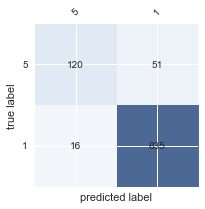

In [62]:
from pylab import rcParams
labels = ['5', '1']
confmat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks,labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()

In [63]:
fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test, y_pred_proba, pos_label=5)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)

### 3.3 TF-IDF Model

#### 3.3.1 Calculate Inverse Document Term Frequency

In [64]:
tfidf_vect = TfidfVectorizer(analyzer = 'word', tokenizer=lemma_tokenizer, lowercase=True)

In [65]:
review_tf = tfidf_vect.fit_transform(yelp_review_df.text)

In [66]:
# Numpy arrays are easy to work with, so convert the result to an array
review_tf_nd = review_tf.toarray()
review_tf_nd.shape

(4086L, 16352L)

In [67]:
# Take a look at how the Document Term Matrix looks
df = pd.DataFrame(review_tf_nd, columns=tfidf_vect.get_feature_names())
df.head(10)

,aaa,aaaamazing,aaammmazzing,aaron,aback,abandoned,abandoning,abba,abbreviate,abbreviated,...,zuccini,zuchinni,zumba,zupa,zupas,zuzu,zuzus,zwftv,zwiebel,zzed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# let's look at the words in the vocabulary, first 100 and last 100
vocab = tfidf_vect.get_feature_names()
print(vocab[:100]) # First 100 words
print(vocab[-100:]) # Last 100 words
#print(vocab)  # all 18k words

[u'aaa', u'aaaamazing', u'aaammmazzing', u'aaron', u'aback', u'abandoned', u'abandoning', u'abba', u'abbreviate', u'abbreviated', u'abby', u'abc', u'abdomen', u'abhor', u'abiding', u'ability', u'abilty', u'able', u'abodoba', u'abou', u'abound', u'abrasion', u'abroad', u'abrupt', u'absence', u'absent', u'absinthe', u'absoloutely', u'absolut', u'absolute', u'absolutely', u'absolutley', u'absolutly', u'absorb', u'absorption', u'abstain', u'abstained', u'abstract', u'absurd', u'abuelo', u'abundance', u'abundant', u'abuse', u'abused', u'abusive', u'abysmal', u'acacia', u'academy', u'acai', u'acapulco', u'accent', u'accented', u'accept', u'acceptable', u'accepted', u'accepting', u'accepts', u'access', u'accessed', u'accessible', u'accessorize', u'accessory', u'accident', u'accidental', u'accidentally', u'accidently', u'acclaimed', u'accolade', u'accommodate', u'accommodated', u'accommodates', u'accommodating', u'accommodation', u'accomodate', u'accomodated', u'accomodating', u'accompanied', 

#### 3.3.2 Fun with World Clouds

**Let's find the most popular words that occur in postive and negative reviews**

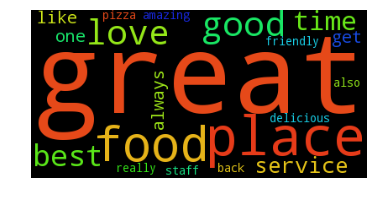

In [69]:
# calculate frequency distribution of words in positive reviews
dist = np.sum(review_tf_nd[np.where(yelp_review_df['stars'] == 5)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count
    
wordcloud = WordCloud().fit_words(counter.most_common(20))
plt.axis("off")
plt.imshow(wordcloud)

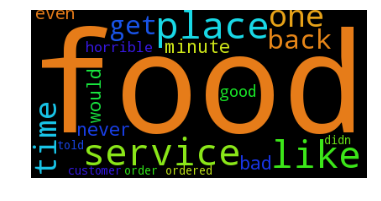

In [70]:
# calculate frequency distribution of words in negative reviews
dist = np.sum(review_tf_nd[np.where(yelp_review_df['stars'] == 1)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count
    
wordcloud = WordCloud().fit_words(counter.most_common(20))
plt.axis("off")
plt.imshow(wordcloud)

#### 3.3.3 Predict the stars rating - A TF-IDF Linear Classifier

In [71]:
# split Train and Validation Data Set
X_train, X_test, y_train, y_test  = train_test_split(review_tf_nd, yelp_review_df['stars'], train_size=0.75)

In [72]:
from sklearn.linear_model import LogisticRegression
# Create and train the Logistic Regression Classifier
log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train, y=y_train)

In [73]:
# Use the classifier to label our evaluation set. We can use either predict for classes or predict_proba for probabilities.
y_pred = log_tfidf_model.predict(X=X_test)
y_pred_prob = log_tfidf_model.predict_proba(X=X_test)[:,1]

In [74]:
# compute precision and recall, or their combination (harmonic mean) F1:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.98      0.31      0.48       198
          5       0.86      1.00      0.92       824

avg / total       0.88      0.87      0.84      1022



In [75]:
print("accuracy: %0.6f" % metrics.accuracy_score(y_test, y_pred))

accuracy: 0.865949


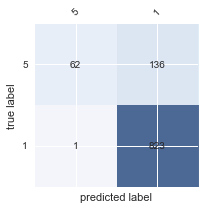

In [76]:
from pylab import rcParams
labels = ['5', '1']
confmat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks,labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()

In [77]:
fpr_tfidf, tpr_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=5)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)

### 3.4 Comparing the the Bag-Of-Words and TF-IDF Models with each other

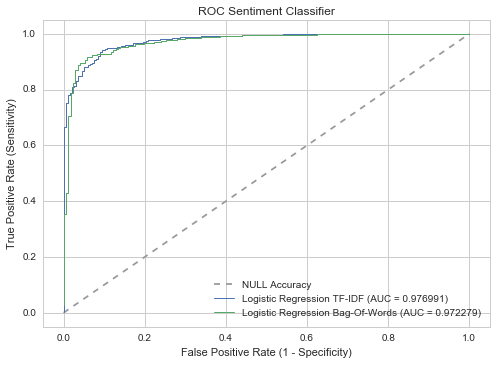

In [78]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression Bag-Of-Words (AUC = %0.6f)' % roc_auc_tf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)